In [786]:
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation, Angle, Latitude, Longitude
from astropy.coordinates import get_moon
from datetime import datetime, timedelta
from shapely.geometry import Point
from astropy.time import Time
from geopandas import GeoDataFrame
import geopandas as gpd
import pandas as pd
import numpy as np
import webbrowser
import sqlite3

In [782]:
#Coordinates of Green Bank Telescope (Telescope used in Observation)
coordinates = EarthLocation.of_site('GBT')
print(coordinates)

(882598.25131862, -4924862.65979072, 3943712.65334219) m


In [783]:
#Create an Observation Time Range
def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

In [784]:
#Time Range Year, Month, Day, Hour, Min
dts = [dt.strftime('%Y-%m-%dT%H:%M') for dt in 
       datetime_range(datetime(2020, 5, 18, 21, 0), datetime(2020, 5, 18, 22, 0), 
       timedelta(minutes=60))]

#Get Julian Days for Zenith Conversion Below
JulianDays = []
for i in dts:
    dt = datetime.strptime(i, '%Y-%m-%dT%H:%M')
    con = sqlite3.connect(":memory:")
    JulianDays = np.append(JulianDays, list(con.execute("select julianday('" +i[:-6]+ "')"))[0][0])
JulianDays[0]

2458987.5

In [785]:
#Example of Moon Position Over a Timerange 
mooncord = get_moon(Time(dts, format='isot', scale='utc'), coordinates)

In [763]:
#Example of a SkyCoord for a Specific Time, 
mooncord[0]

<SkyCoord (GCRS: obstime=['2020-05-18T21:00:00.000'], obsgeoloc=[(-1858641.18028311, 4642180.06903626, 3947371.09385351)] m, obsgeovel=[(-338.51405372, -136.09378502, 0.65751132)] m / s): (ra, dec, distance) in (deg, deg, km)
    (15.25686086, 0.83314783, 405888.39789026)>

In [764]:
mooncord[0].ra

<Longitude 15.25686086 deg>

# Approach to Calculating Moon Sub-Point

Given a date and time, the position of the Moon can be calculated to provide the declination and right ascension. The sub-point of the Moon (the point on the Earth at which the Moon is at the zenith) is as follows:

- latitude = declination of the Moon

- longitude can be found by calculating the local mean sidereal time (LMST) that equals the Moon's right ascension. (LMST dependents on the date, time, and longitude.) Everything is known except for the longitude.

## Method (using GMST)

- Calculate the Local Mean Sidereal Time (LMST) where GMST is the Greenwich Mean Sidereal Time and 𝑙𝑜𝑛𝑔𝑒𝑎𝑠𝑡 is the longitude with positive values in the eastern hemisphere

   𝐿𝑀𝑆𝑇=𝐺𝑀𝑆𝑇+𝑙𝑜𝑛𝑔𝑒𝑎𝑠𝑡

- The Astronomical Almanac gives an expression for approximate mean sidereal time, in hours: 

    GMST=6.697374558+0.06570982441908 𝐷 +1.00273790935 𝐻 +0.000026 𝑇^2

- Where GMST is the mean sidereal time in hours, 𝐻 is the universal time at the time in question, 𝐷0 is the Julian date on the previous midnight of the time in question less 2451545.0, 𝐷 is the Julian date at the time in question (including fractional days) less 2451545.0, and 𝑇 is 𝐷/36525. The relationship between 𝐷0 is quite simple: 𝐷0=𝐷−𝐻/24. Substituting this in the above and omitting the quadratic term yields

    GMST=6.697374558+0.06570982441908(𝐷−𝐻/24)+1.00273790935𝐻
        = =6.697374558+0.06570982441908𝐷+𝐻
    
- Multiplying by 15 yields the GMST in degrees:

    GMST_deg=100.4606184+0.9856473662862𝐷+15𝐻
 





In [789]:
#Generate Lat, Long Sub-Point Based on the Method Described Above of all Observation Times
lat = []
long = []
JD = 2451545
for i in range(len(mooncord)):
    Time = dts[i]
    lat = np.append(lat, float(str(mooncord[i].dec*u.degree)[:-5]))
    LMST = float(str(mooncord[i].ra*u.degree)[:-4])%360
    D = JulianDays[i] - JD
    GMST = (100.4606184 + 0.9856473662862 * D + 15*int(Time[11:13]))%360
    print(Time, "LMST:", LMST, "GMST:", GMST)
    temp = LMST - GMST 
    if temp < -180:
        temp = 360 + temp
    elif temp > 180:
        temp = temp - 360
        
    long = np.append(long, temp)
long[0]

2020-05-18T21:00 LMST: 15.256860863511582 GMST: 191.14114198504376


-175.88428112153218

#### Create A Pandas Dataframe and use GeoDataFrame to graph subpoints

In [769]:

data = {'Longitude': long,'Latitude': lat, 'Observation Time UTC': dts}
df = pd.DataFrame(data, columns = ['Longitude','Latitude', 'Observation Time UTC'])
calculations = df

In [770]:
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   

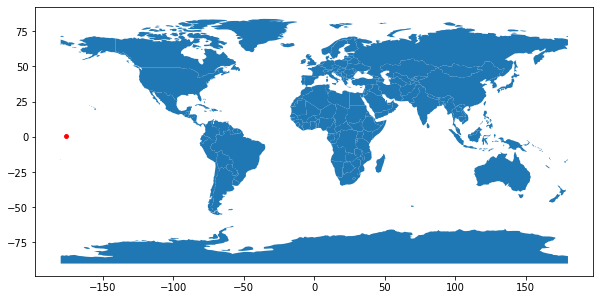

In [771]:
#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

In [791]:
df2= df[:1]
moonlong = df2['Longitude'].loc[0]
moonlat = df2['Latitude'].loc[0]
obstime = df2['Observation Time UTC'].loc[0]
df2 = df2.iloc[:, :-1]
df2
#Example of Dataframe row below 

,Longitude,Latitude,Observation Time UTC
0,-175.884281,0.833148,2020-05-18T21:00


In [773]:
#Setting Sides of Moon Long
if moonlong +90 > 180:
    df2.loc[1] = [moonlong-180, moonlat, obstime]
else:
    df2.loc[1] = [moonlong+90, moonlat, obstime]
if moonlong -90 < -180:
    df2.loc[2] = [180 - abs(moonlong - 90 + 180), moonlat, obstime]
else:
    df2.loc[2] = [moonlong-90, moonlat, obstime]
#Setting Sides of Moon Lat
if moonlat +90 > 90:
    df2.loc[3] = [moonlong, moonlat-90, obstime]
else:
    df2.loc[3] = [moonlong, moonlat+45, obstime]

In [774]:
geometry = [Point(xy) for xy in zip(df2['Longitude'], df2['Latitude'])]
gdf = GeoDataFrame(df2, geometry=geometry)   
gdf

,Longitude,Latitude,Observation Time UTC,geometry
0,-175.884281,0.833148,2020-05-18T21:00,POINT (-175.88428 0.83315)
1,-85.884281,0.833148,2020-05-18T21:00,POINT (-85.88428 0.83315)
2,94.115719,0.833148,2020-05-18T21:00,POINT (94.11572 0.83315)
3,-175.884281,-89.166852,2020-05-18T21:00,POINT (-175.88428 -89.16685)


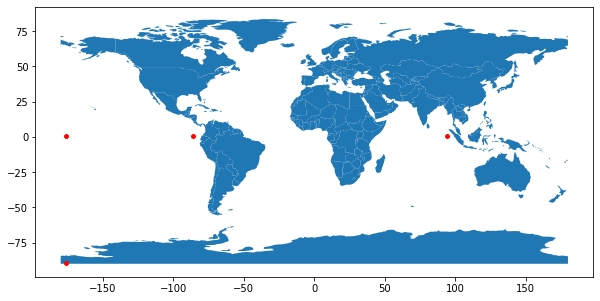

In [775]:
#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

In [776]:
date= str(dts[0])
lat = lat[0]
long = long[0]
zoom = 17
date = 
time =
objectlevel = 324.0
maptype = 2
# generate an URL of 
url = "https://mooncalc.org/#/"+lat","+lon+","+zoom+"/"+date+"/"+time+"/"+objectlevel+"/"+maptype
webbrowser.open(url)

SyntaxError: invalid syntax (<ipython-input-776-d23a7ffa7ca9>, line 5)

In [582]:
#Solve the system of equations 3 * x0 + x1 = 9 and x0 + 2 * x1 = 8:
geocentric = np.array([[ra,dec,distance], [0,0, -distance]])
b = np.array([9,8])
x = np.linalg.solve(a, b)
x

NameError: name 'ra' is not defined